In [ ]:
# default_exp core

# core

> Core functions to run experiments

In [ ]:
# hide
from nbdev.showdoc import *

%load_ext nb_black
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [ ]:
# export
from torchvision.datasets import FashionMNIST
import numpy as np

import torch
import torch as th
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter

from newremagine import vae
from newremagine import recall

import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [ ]:
# export
def train(
    fraction,
    train_dataset,
    num_episodes=10,
    batch_size=10,
    num_burn=1,
    lr=0.001,
    device="cpu",
    perfect=True,
    recall_name="Recall",
    recall_kwargs=None,
    vae_name="VAE",
    vae_kwargs=None,
):

    # -- Init memories
    if recall_kwargs is None:
        recall_kwargs = {}
    if vae_kwargs is None:
        vae_kwargs = {}

    Recall = getattr(recall, recall_name)
    memory = Recall(**recall_kwargs)

    VAE = getattr(vae, vae_name)
    model = VAE(**vae_kwargs).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # -- Everything is sane?
    num_episodes = int(num_episodes)
    num_burn = int(num_burn)
    lr = float(lr)
    if not np.isclose(sum(fraction), 1):
        raise ValueError("fractions must sum to 1")

    # -- !
    options = ["new", "recall", "imagine"]
    batch_idx = 0
    for n in range(num_episodes):
        # Burn in the model, or consider other options?
        if n < num_burn:
            option = "new"
        else:
            option = np.random.choice(options, p=fraction)

        # Make/get training data
        if option == "new":
            # Get new data
            train_batch = [
                train_dataset[i][0] for i in range(batch_idx, batch_idx + batch_size)
            ]
            train_batch = torch.stack(train_batch)
            batch_idx += batch_size
            # If the memory is perfect we recall the
            # training data later but If the memory
            # is imperfect we add the reconstructed data
            # the the memory intead.
            if perfect:
                memory.encode(train_batch)
            else:
                with torch.no_grad():
                    recon_batch, _, _ = model(train_batch)
                    memory.encode(recon_batch)
        elif option == "recall":
            train_batch = memory.sample(1)
        else:
            # Sampling from the VAE model is a kind of
            # imagination, or so we imagine in here
            train_batch = model.sample(batch_size, device=device)

        # Train the vae/model
        loss = vae.train(train_batch, model, optimizer, device, model.input_dim)

    return model, memory, float(loss)

<IPython.core.display.Javascript object>

In [ ]:
# test
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST

train_dataset = MNIST(
    "data/", download=True, train=True, transform=transforms.ToTensor()
)

fraction = [1.0, 0.0, 0.0]
model, memory, loss = train(
    fraction, train_dataset, num_episodes=5000, num_burn=100, lr=0.001, perfect=False
)
print(loss)

1487.509033203125


<IPython.core.display.Javascript object>

In [ ]:
# export
def test(model, test_dataset, device="cpu"):
    return vae.test(test_dataset, model, device, model.input_dim)

<IPython.core.display.Javascript object>

In [ ]:
# test
test_dataset = MNIST(
    "data/", download=True, train=False, transform=transforms.ToTensor()
)
test(model, test_dataset)

1485410.6534729004

<IPython.core.display.Javascript object>

In [ ]:
# export
def plot_latent(model, batch_size, img_size=28):
    """Display samples from the latent space."""
    # Make a display grid
    figure = np.zeros((img_size * batch_size, img_size * batch_size))

    # MAke data
    x = model.sample(batch_size ** 2)
    x = x.flatten().numpy().reshape(batch_size ** 2, img_size, img_size)
    imgs = [x[i, ::] for i in range(batch_size ** 2)]

    # !
    k = 0
    for i in range(batch_size):
        for j in range(batch_size):
            figure[
                i * img_size : (i + 1) * img_size, j * img_size : (j + 1) * img_size
            ] = imgs[k]
            k += 1

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap="gray")
    plt.axis("off")
    plt.show()

<IPython.core.display.Javascript object>

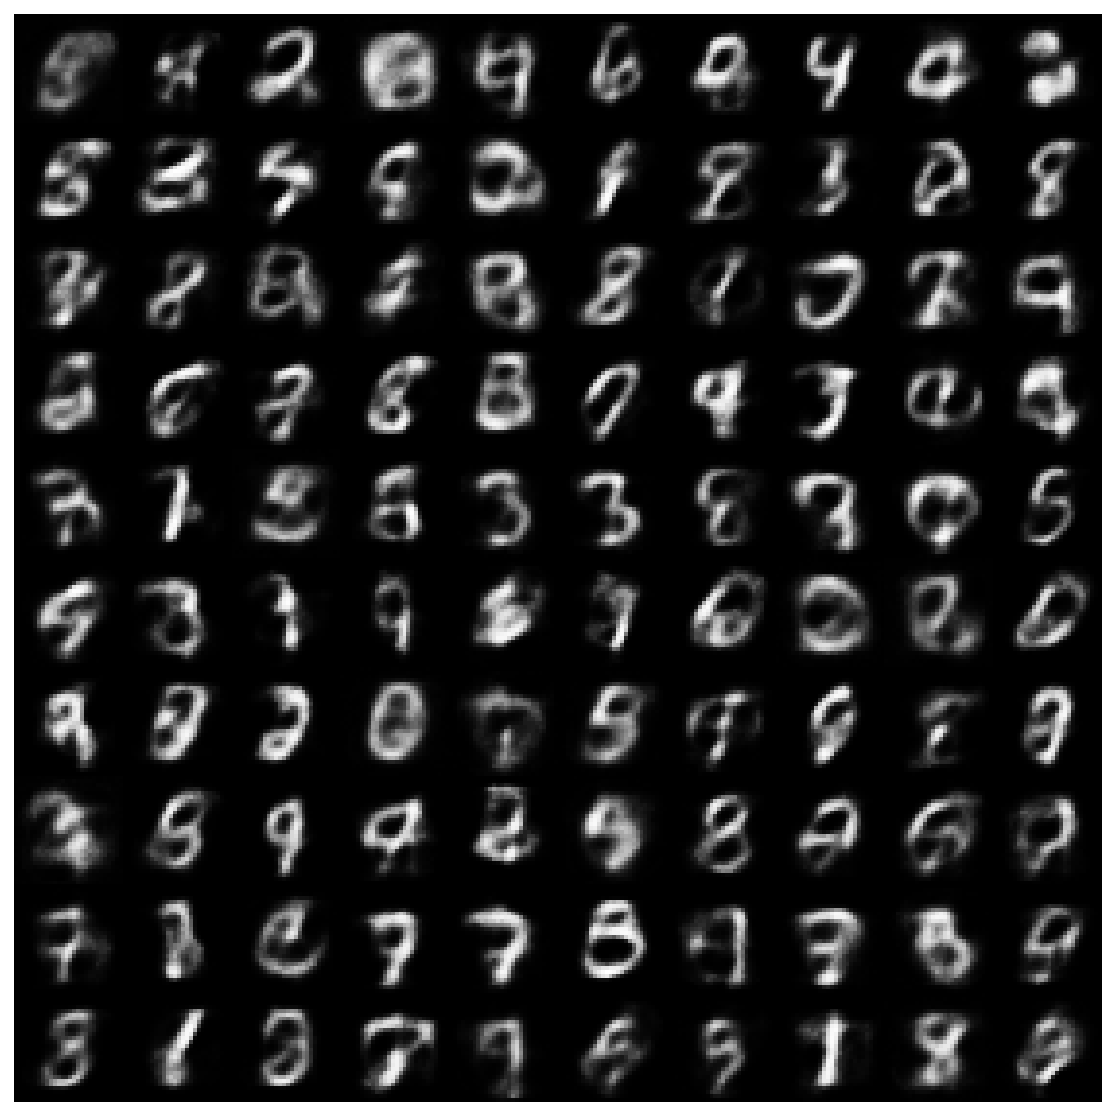

<IPython.core.display.Javascript object>

In [ ]:
# test
plot_latent(model, 10)

In [ ]:
# export
from itertools import product
from copy import deepcopy


def plot_test(test_dataset, model, batch_size, img_size=28):
    """Display random samples from the test data."""
    # Make a display grid
    figure = np.zeros((img_size * batch_size, img_size * batch_size))

    # Choose data
    idx = np.random.randint(0, len(test_dataset), size=batch_size ** 2)

    # !
    imgs = []
    for i in idx:
        with torch.no_grad():
            x, _ = test_dataset[i]
            x_reconst, _, _ = model(x)

        img = x_reconst.unsqueeze(0).numpy().flatten().reshape(img_size, img_size)
        imgs.append(deepcopy(img))

    k = 0
    for i in range(batch_size):
        for j in range(batch_size):
            figure[
                i * img_size : (i + 1) * img_size, j * img_size : (j + 1) * img_size
            ] = imgs[k]
            k += 1

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap="gray")
    plt.axis("off")
    plt.show()

<IPython.core.display.Javascript object>

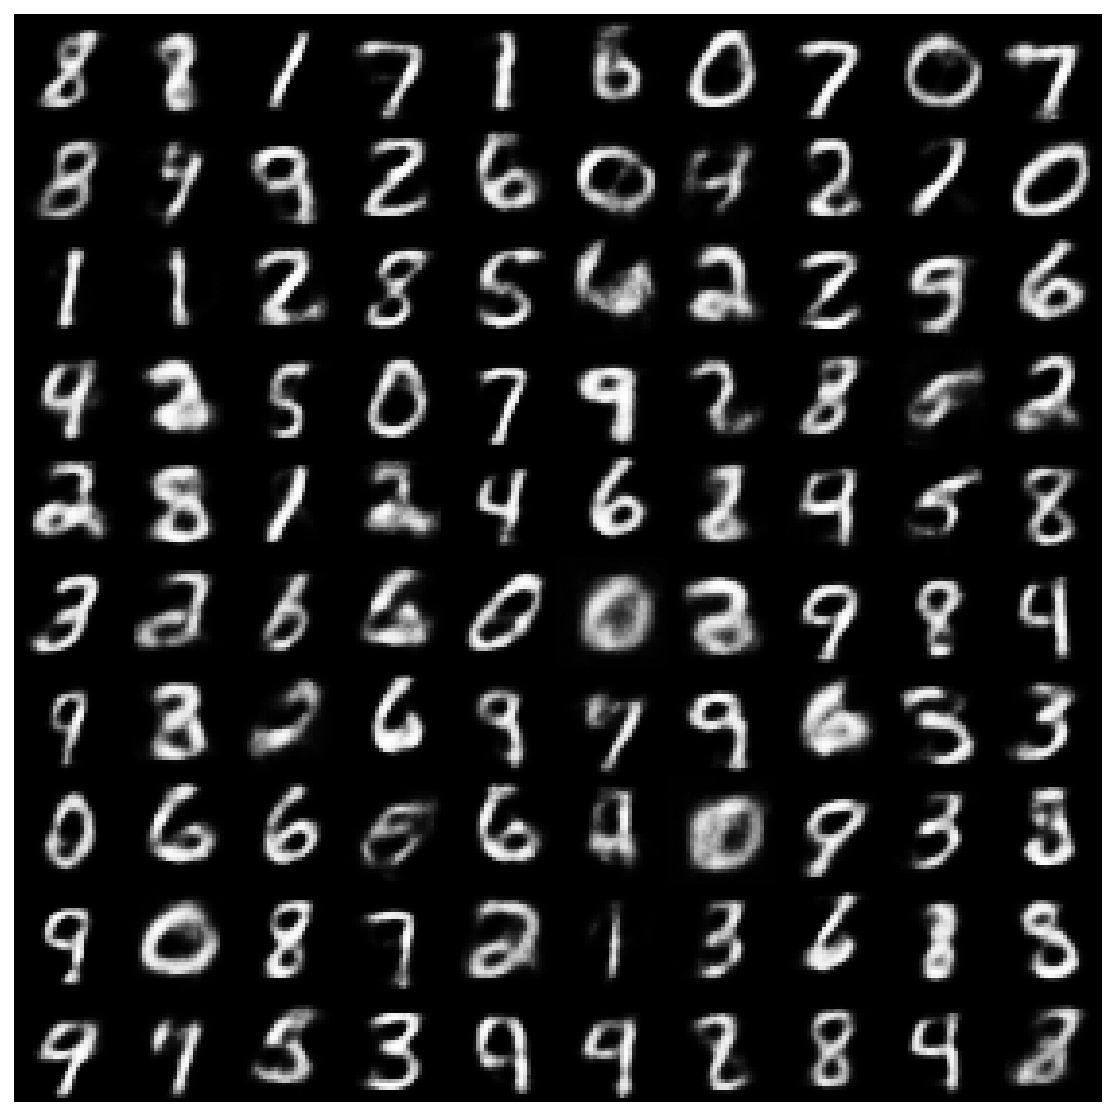

<IPython.core.display.Javascript object>

In [ ]:
# test
plot_test(test_dataset, model, 10)